In [104]:
import os
import re
from collections import defaultdict

In [105]:
#log_filename = "../simulation_results/hoya/transport_output_messages.txt"
#log_filename = "../simulation_results/hoya/inertial_output_messages.txt"
#log_filename = "../simulation_results/hoya_iranian/transport_output_messages.txt"
log_filename = "../simulation_results/hoya_iranian/out_iranian_50_05_02_transport_classic.txt"
dim = 50,50
patt_out_line = "\{\((?P<x>\w+),(?P<y>\w+)\).*<(?P<state>[\w,. -]+)>"

In [106]:
COLOR_SUSCEPTIBLE = "#3498db"
COLOR_INFECTED = "#e74c3c"
COLOR_RECOVERED = "#2ecc71"

In [107]:
"""def time_str_to_ts(time_str):
  patt_time = "([0-9]{2}):([0-9]{2}):([0-9]{2}):([0-9]{3})"
  match = re.match(patt_time, time_str)
  if not match:
    raise RuntimeError("Error converting simulation time")
  tu = list(map(int, match.groups()))
  return tu[3] + tu[2]*1000 + tu[1]*60000 + tu[0]*3600000"""

def curr_states_to_df_row(sim_time, curr_states):
    sus_acc = 0
    inf_acc = 0
    rec_acc = 0
    for i in range(len(curr_states)):
        for j in range(len(curr_states[0])):
            #print(curr_states[i][j])
            sus, inf, rec = curr_states[i][j]
            sus_acc += sus
            inf_acc += inf
            rec_acc += rec
            
            assert 0.999 <= sus + inf + rec < 1.001, (curr_time, i, j,sus + inf + rec)
            
    num_cells = len(curr_states) * len(curr_states[0])
    sus_acc /= num_cells
    inf_acc /= num_cells
    rec_acc /= num_cells
    
    assert 0.999 <= sus_acc + inf_acc + rec_acc < 1.001, (curr_time, sus_acc + inf_acc + rec_acc)
    
    return [int(sim_time), sus_acc, inf_acc, rec_acc]

In [108]:
curr_time = None
curr_states = []

for _ in range(dim[0]):
    curr_states.append([])
    for _ in range(dim[1]):
        curr_states[-1].append([1, 0, 0])

In [109]:
states = ["sus", "infec", "rec"]
data = []
curr_data = []

with open(log_filename, "r") as log_file:
    for line in log_file:
        line = line.strip()
        if line.isnumeric() and line != curr_time:
            curr_time = line
            data.append(curr_states_to_df_row(curr_time, curr_states))
            continue

        #print(line)
        match = re.search(patt_out_line, line)
        if not match:
            print(line)
            continue

        x = int(match.group("x"))
        y = int(match.group("y"))

        state = list(map(float, match.group("state").split(",")[-3:]))
        #print("Modifying %d,%d" % (x,y), state)
        curr_states[x][y] = state
        
    data.append(curr_states_to_df_row(curr_time, curr_states))

0


In [110]:
data

[[0, 1.0, 0.0, 0.0],
 [1, 0.9998799999999999, 0.00011999999999999999, 0.0],
 [2, 0.9998360000000001, 0.00011600000000000001, 4.8e-05],
 [3, 0.9997360000000001, 0.000168, 9.6e-05],
 [4, 0.9996200000000001, 0.00022400000000000002, 0.000156],
 [5, 0.9994559999999999, 0.0003, 0.00024400000000000005],
 [6, 0.9992120000000002, 0.000408, 0.00038],
 [7, 0.998936, 0.0005480000000000002, 0.0005160000000000001],
 [8, 0.9985000000000004, 0.000756, 0.0007440000000000001],
 [9, 0.9979680000000001, 0.0009799999999999998, 0.0010519999999999998],
 [10, 0.9973439999999999, 0.0012319999999999996, 0.0014239999999999995],
 [11, 0.9965120000000003, 0.0015480000000000001, 0.0019399999999999999],
 [12, 0.9955240000000009, 0.0019119999999999988, 0.002564],
 [13, 0.9951200000000001, 0.001564, 0.0033160000000000004],
 [14, 0.9947960000000005, 0.0012839999999999998, 0.00392],
 [15, 0.9945200000000001, 0.001056, 0.004423999999999998],
 [16, 0.9943559999999994, 0.0008280000000000003, 0.004816],
 [17, 0.993891999999

### Visualization

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [112]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [113]:
columns = ["time", "susceptible", "infected", "recovered"]
df_vis = pd.DataFrame(data, columns=columns)
df_vis = df_vis.set_index("time")
df_vis.to_csv("states.csv")
df_vis.head()

,susceptible,infected,recovered
time,,,
0,1.000000,0.000000,0.000000
1,0.999880,0.000120,0.000000
2,0.999836,0.000116,0.000048
3,0.999736,0.000168,0.000096
4,0.999620,0.000224,0.000156


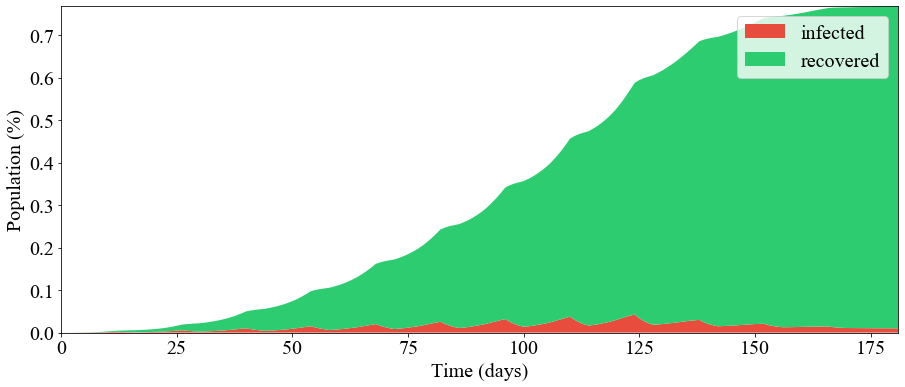

In [114]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["infected", "recovered"]
colors=[COLOR_INFECTED, COLOR_RECOVERED]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(15,6))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_area.pdf")

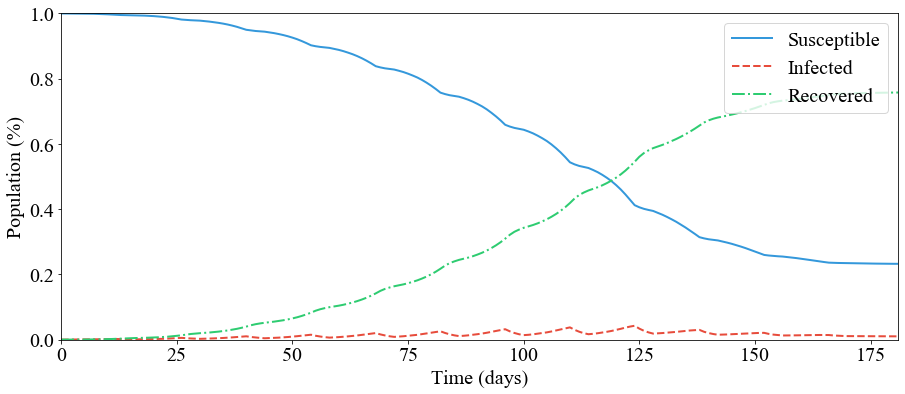

In [115]:
fig, ax = plt.subplots(figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["infected"], label="Infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_lines.pdf")